# EDA notebook

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna-ts/master?filepath=examples/EDA.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of EDA (exploratory data analysis) using ETNA library.

**Table of Contents**

* [Creating TSDataset](#chapter1)  
* [Visualization](#chapter2)
    * [Plot](#section_2_1)
    * [Partial autocorrelation](#section_2_2)
    * [Cross-correlation](#section_2_3)
    * [Correlation heatmap](#section_2_4)
    * [Distribution](#section_2_5)
* [Outliers](#chapter3)
    * [Median method](#section_3_1)
    * [Density method](#section_3_2)
    * [Sequence anomalies](#section_3_3)

    

In [1]:
import warnings
warnings.filterwarnings("ignore")

### 1. Creating TSDataset <a class="anchor" id="chapter1"></a>

Let's load and look at the dataset

In [2]:
import pandas as pd

In [3]:
classic_df = pd.read_csv("data/example_dataset.csv")
classic_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the spacial data structure TSDataset. So, before starting the EDA, we need to convert the classical DataFrame to TSDataset.

In [4]:
from etna.datasets.tsdataset import TSDataset

To do this, we initially need to convert the classical DataFrame to the special format

In [5]:
df = TSDataset.to_dataset(classic_df)
df.head()

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


Now we can construct the TSDataset

In [6]:
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


TSDataset implements a lot of methods of DataFrame. For example, we can explore the dataset description using the traditional pandas method.

In [7]:
ts.describe()

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
count,365.000000,365.000000,365.000000,365.000000
mean,465.600000,217.369863,144.364384,660.556164
std,79.469629,35.429355,47.444836,175.069783
min,170.000000,102.000000,92.000000,238.000000
25%,409.000000,189.000000,122.000000,531.000000
50%,479.000000,224.000000,136.000000,636.000000
75%,515.000000,242.000000,155.000000,774.000000
max,705.000000,310.000000,792.000000,1091.000000


### 2. Visualization<a class="anchor" id="chapter2"></a>

Our library provides a list of utilities for visual data exploration. So, having the dataset converted to TSDataset, now we can visualize it.

In [8]:
from etna.analysis import (
    cross_corr_plot,
    distribution_plot,
    sample_pacf_plot,
    plot_correlation_matrix
)

#### 2.1 Ploting time series <a class="anchor" id="section_2_1"></a>
Let's take a look at the time series in the dataset

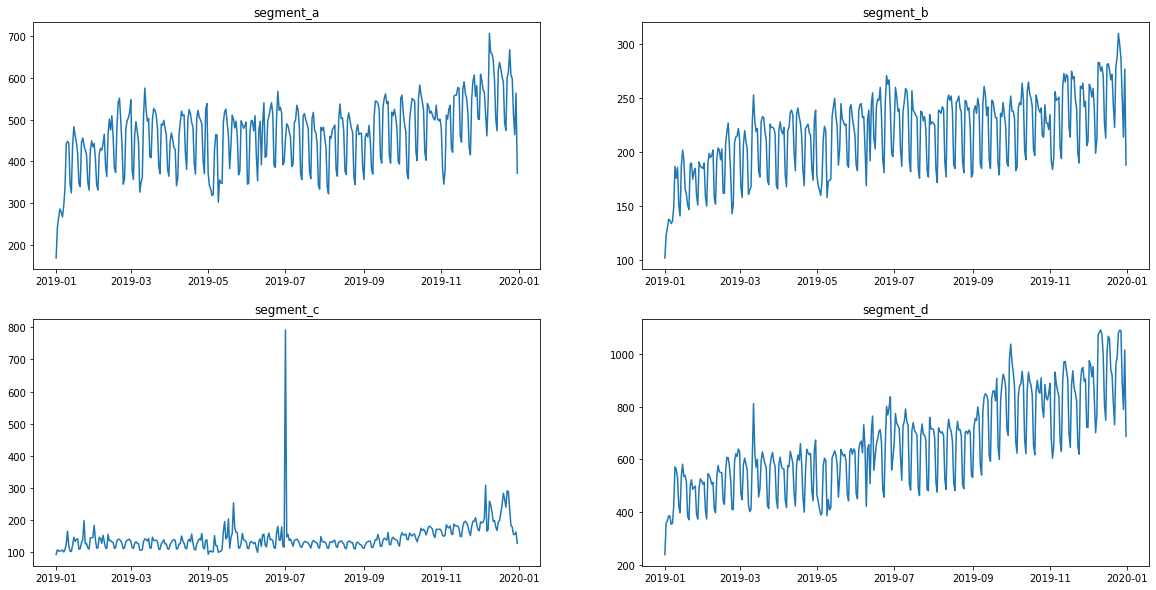

In [9]:
ts.plot()

#### 2.2 Partial autocorrelation<a class="anchor" id="section_2_2"></a>
Partial autocorrelation function(**PAFC**) describes the direct relationship between an observation and its lag. The PAFC plot can help to identify the extent of the lag in autoregressive models.

Let's observe the PAFC plot for our time series, specifying the maximum number of lags



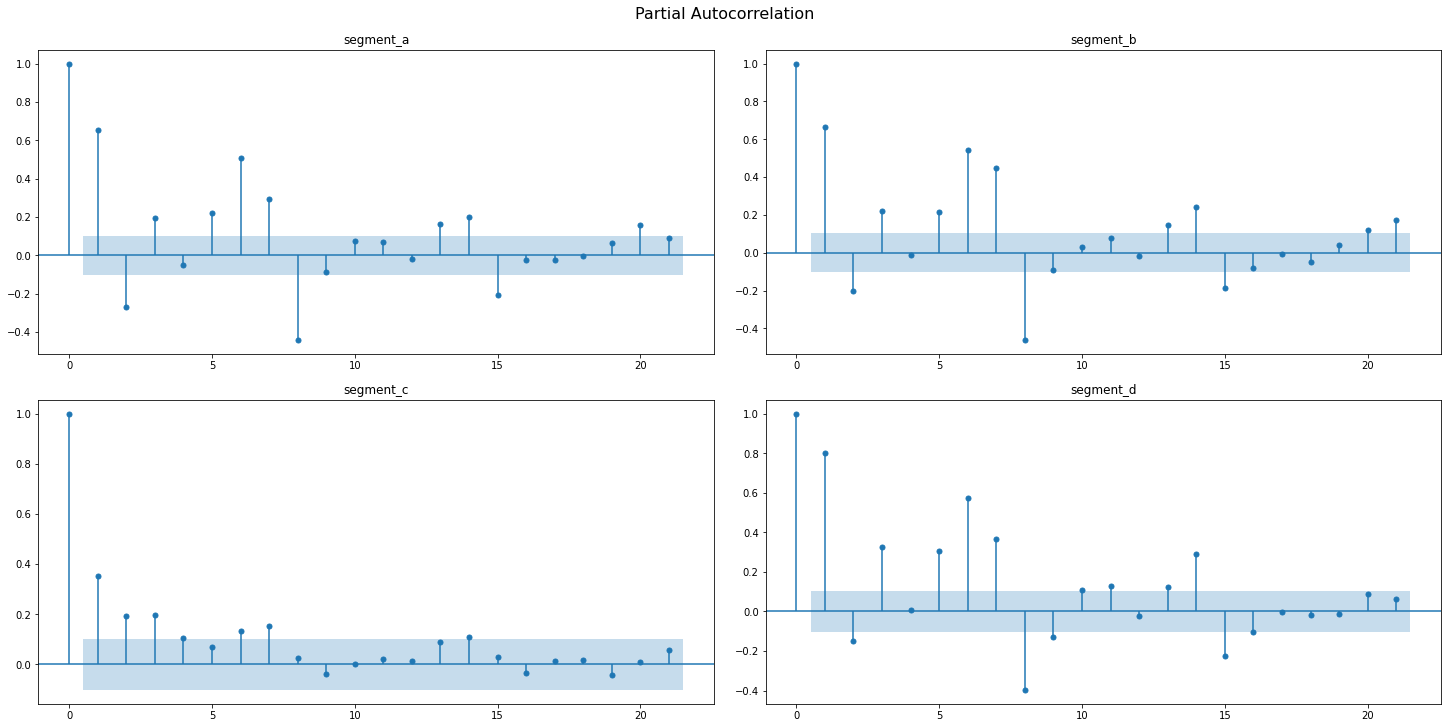

In [10]:
sample_pacf_plot(ts, lags=21)

#### 2.3 Cross-correlation<a class="anchor" id="section_2_3"></a>
Cross-correlation is generally used to compare multiple time series and determine how well they match up with each other and, in particular, at what point the best match occurs. The closer the cross-correlation value is to $1$, the more closely the sets are identical.

Let's plot the cross-correlation for all pairs of time series in our dataset


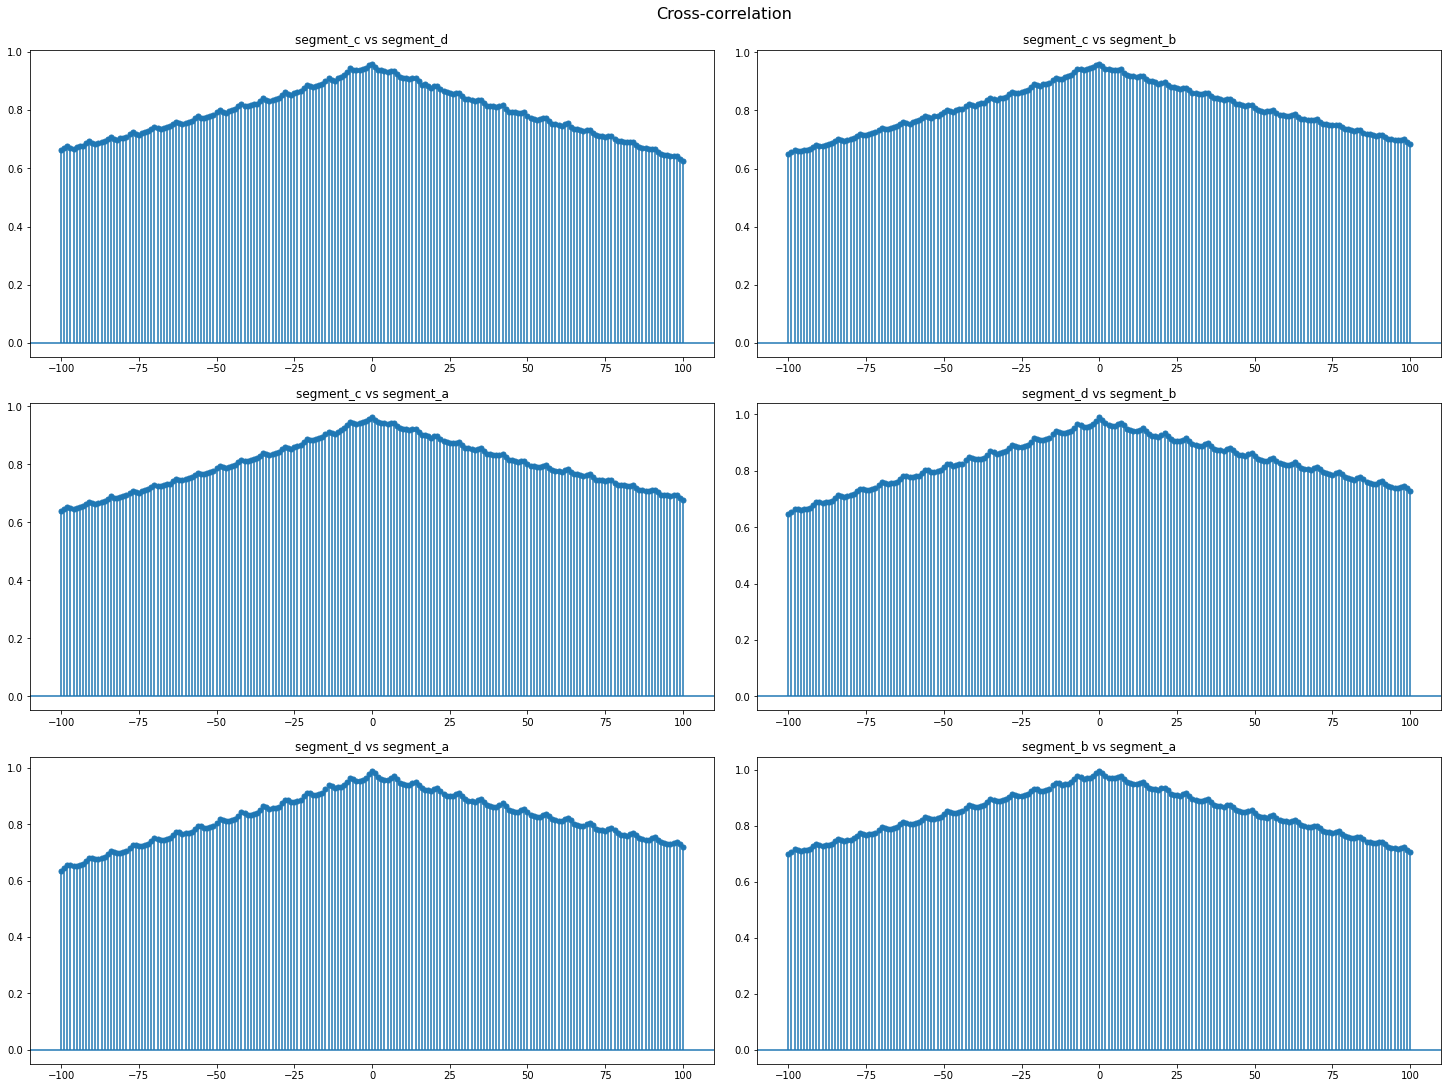

In [11]:
cross_corr_plot(ts, maxlags=100)

#### 2.4 Correlation heatmap <a class="anchor" id="section_2_4"></a>

Correlation heatmap is a visualization of pairwise correlation matrix between timeseries in a dataset. It is a simple visual tool which you may use to determine the correlated timeseries in your dataset. 

Let's take a look at the correlation heatmap, adding lags columns to the dataset to catch the series that are correlated but with some shift.

In [12]:
from etna.transforms import LagTransform

In [13]:
lags = LagTransform(in_column="target", lags=[1,7], out_column="regressor_lag")
ts.fit_transform([lags])

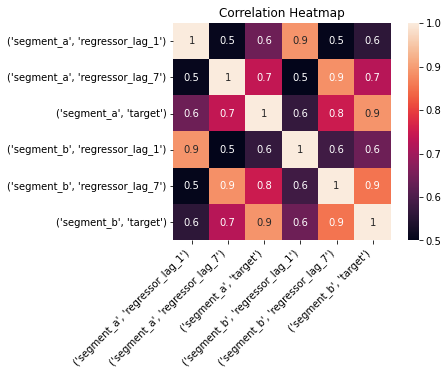

In [14]:
plot_correlation_matrix(ts, segments=["segment_a","segment_b"], method="spearman", vmin=0.5, vmax=1)

#### 2.5 Distribution <a class="anchor" id="section_2_5"></a>
Distribution of z-values grouped by segments and time frequency. Using this plot, you can monitor the data drifts over time.

Let's compare the distributions over each year in the dataset

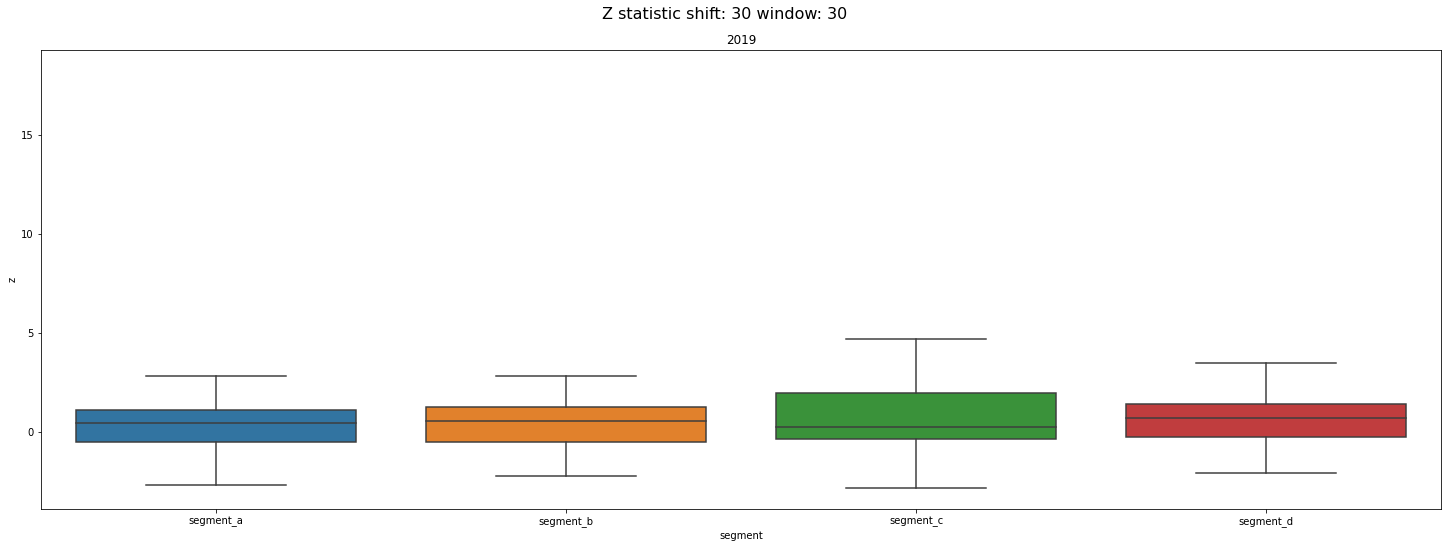

In [15]:
distribution_plot(ts, freq="1Y")

### 3. Outliers <a class="anchor" id="chapter3"></a>

Visually, all the time series contain outliers - abnormal spikes on the plot. Their presence might cause the reduce in predictions quality.

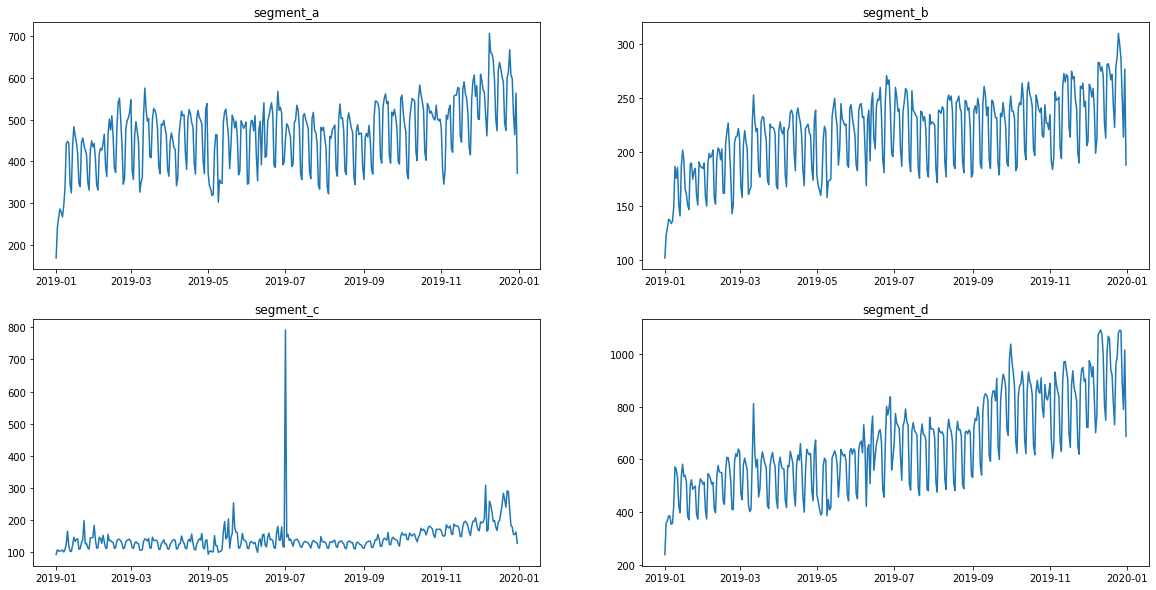

In [16]:
ts.plot()

In our library, we provide two methods for outliers detection. In addition, you can easily visualize the detected outliers using ```plot_anomalies```


In [17]:
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density, get_sequence_anomalies
from etna.analysis import plot_anomalies

#### 3.1 Median method<a class="anchor" id="section_3_1"></a>
To obtain the point outliers using the median method we need to specify the *window* for fitting the median model.

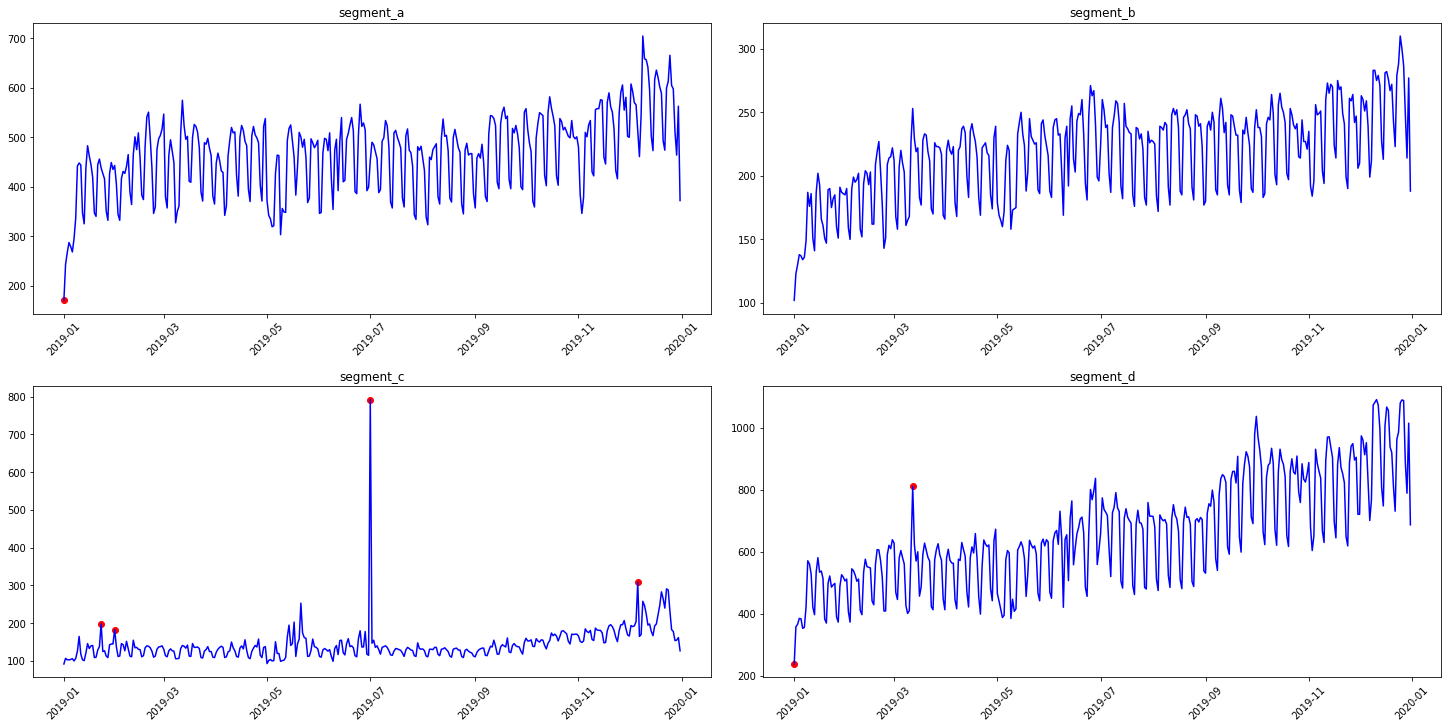

In [18]:
anomaly_dict = get_anomalies_median(ts, window_size=100)
plot_anomalies(ts, anomaly_dict)

#### 3.2 Density method<a class="anchor" id="section_3_2"></a>
It is a distance-based method for outliers detection. Don't rely on default parameters)

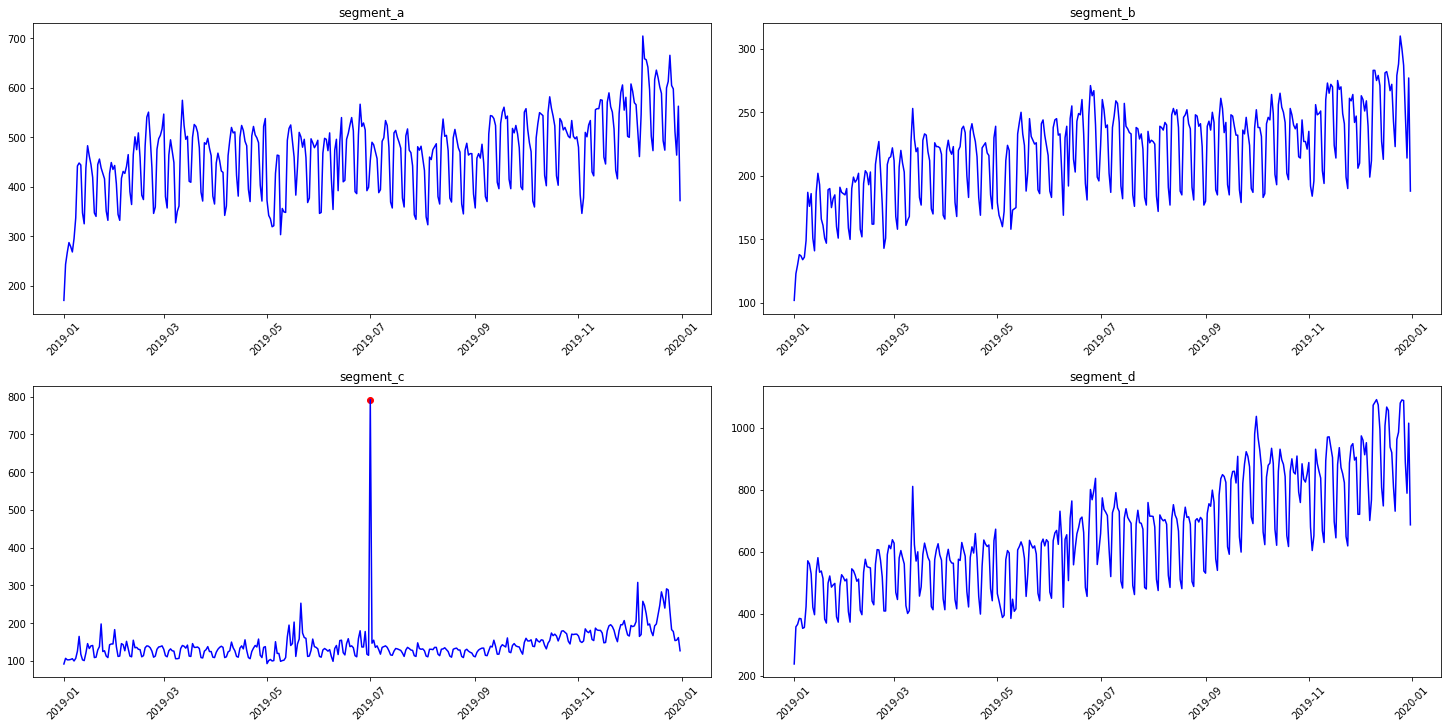

In [19]:
anomaly_dict = get_anomalies_density(ts)
plot_anomalies(ts, anomaly_dict)

The best practice here is to specify the method parameters for your data

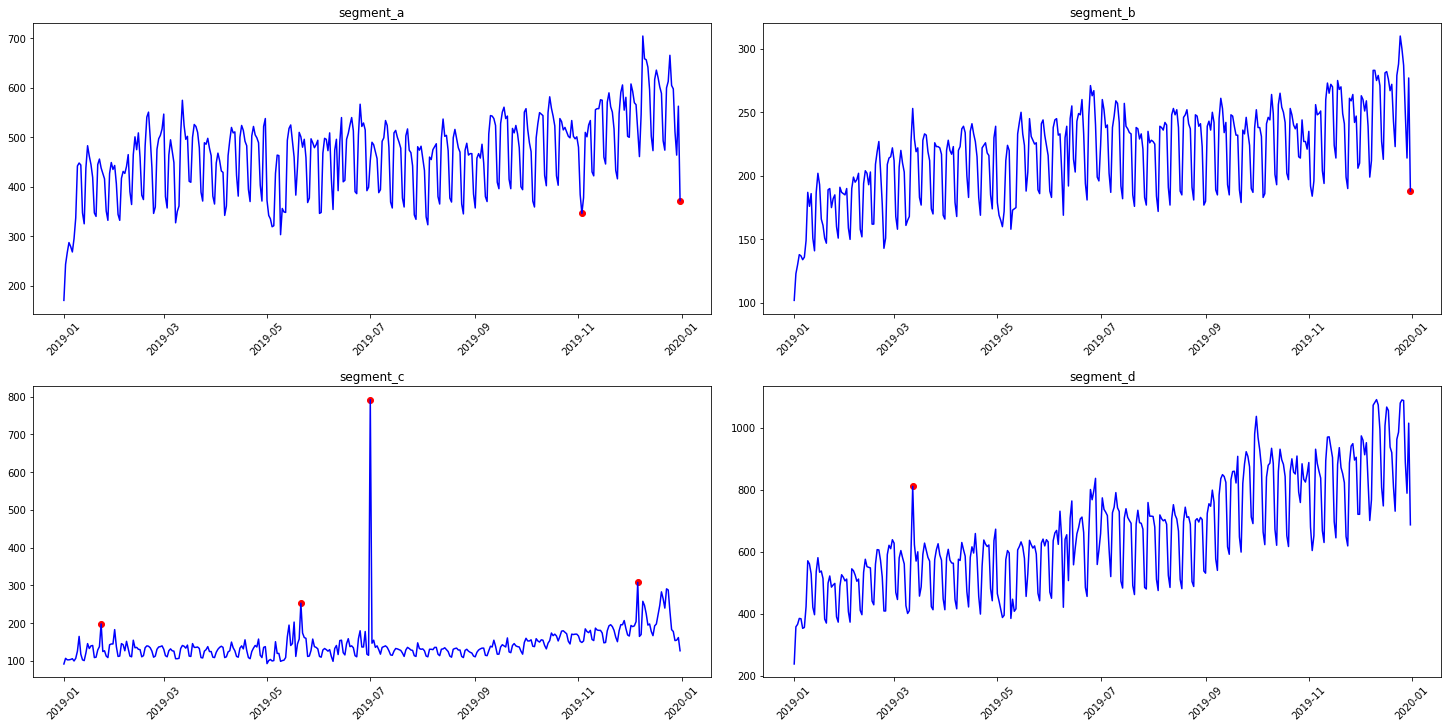

In [20]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

#### 3.3 Sequence anomalies<a class="anchor" id="section_3_3"></a>

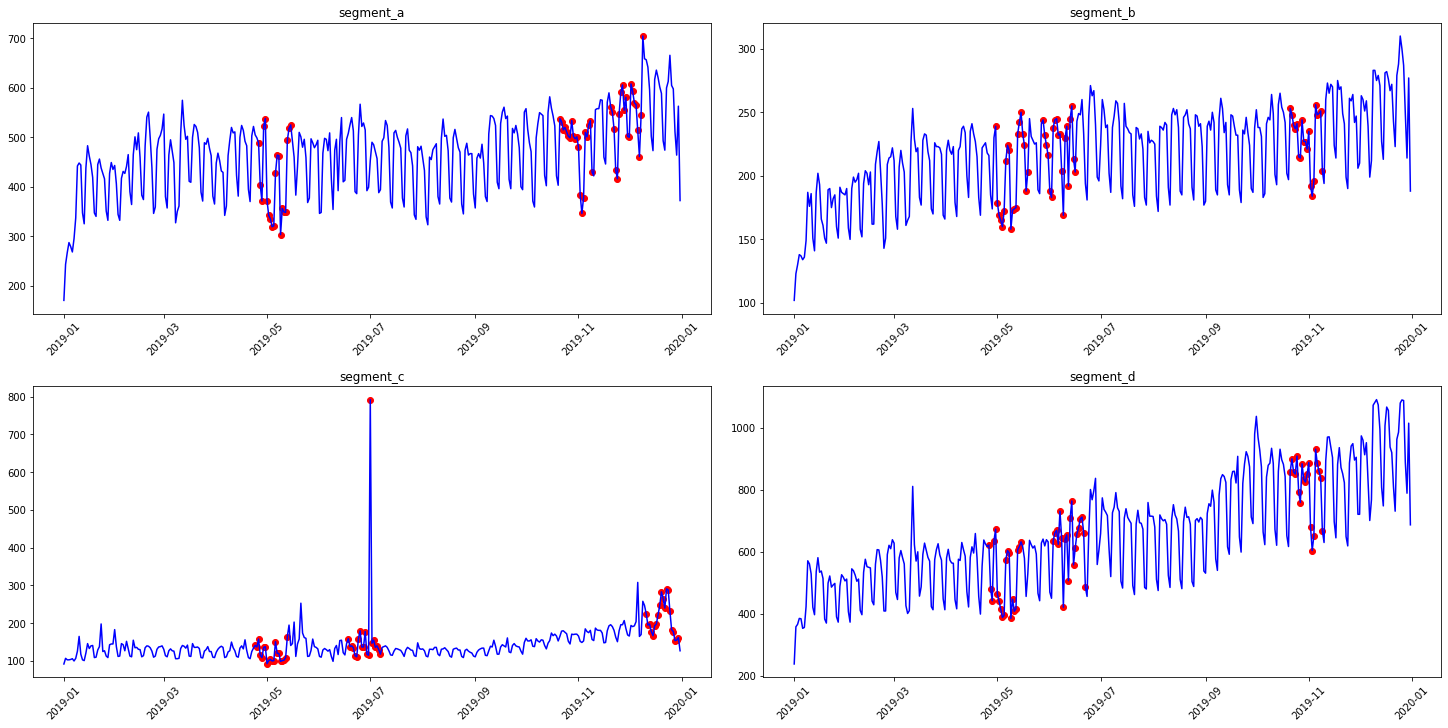

In [21]:
anomaly_seq_dict = get_sequence_anomalies(ts, num_anomalies = 3, anomaly_length = 20)
plot_anomalies(ts, anomaly_seq_dict)

That's all for this notebook. More features for time series analysis you can find in our documentation.